# DLRM Ranking Model

In [1]:
import os

from merlin.datasets.entertainment import get_movielens

input_path = os.environ.get("INPUT_DATA_DIR", os.path.expanduser("~/merlin-framework/movielens/"))

get_movielens(variant="ml-1m", path=input_path);

2023-07-05 10:26:20.573752: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/torch.py:43: UserWarning: PyTorch dtype mappings did not load successfully due to an error: No module named 'torch'
  warn(f"PyTorch dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
ls {input_path}/ml-1m #noqa

README                    ratings.dat    users.dat
movies.dat                train.parquet  users_converted.parquet
movies_converted.parquet  transformed/   valid.parquet


In [3]:
from merlin.core.dispatch import get_lib

train = get_lib().read_parquet(f'{input_path}ml-1m/train.parquet')
valid = get_lib().read_parquet(f'{input_path}ml-1m/valid.parquet')

In [4]:
train.head()

,userId,movieId,rating,timestamp
348678,2043,2976,1,974666164
348785,2046,318,5,974666372
447226,2755,2721,5,973192895
607075,3685,2804,4,966861784
249905,1505,1732,3,983671138


In [5]:
import nvtabular as nvt
from merlin.schema.tags import Tags

train_ds = nvt.Dataset(train)
valid_ds = nvt.Dataset(valid)

train_ds, valid_ds

(<merlin.io.dataset.Dataset at 0x7f81d006cd90>,
 <merlin.io.dataset.Dataset at 0x7f81d006cc40>)

In [32]:
categorical_features = ['userId', 'movieId'] >> nvt.ops.Categorify()

In [34]:
target = ['rating'] >> nvt.ops.LambdaOp(lambda x: (x>3).astype('int')) >> nvt.ops.AddMetadata(tags=[Tags.BINARY_CLASSIFICATION, Tags.TARGET])

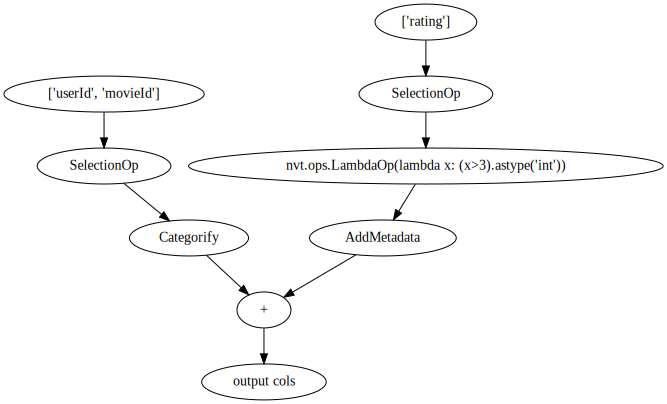

In [35]:
output = categorical_features+target

In [9]:
workflow = nvt.Workflow(output)

In [10]:
workflow.fit_transform(train_ds).to_parquet('train')
workflow.transform(valid_ds).to_parquet('valid')

In [11]:
train_transformed = nvt.Dataset('train', engine='parquet')
valid_transformed = nvt.Dataset('valid', engine='parquet')

In [12]:
train_transformed.schema

,name,tags,dtype,is_list,is_ragged,properties.num_buckets,properties.freq_threshold,properties.max_size,properties.cat_path,properties.embedding_sizes.cardinality,properties.embedding_sizes.dimension,properties.domain.min,properties.domain.max,properties.domain.name
0,userId,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,.//categories/unique.userId.parquet,6043.0,210.0,0.0,6042.0,userId
1,movieId,(Tags.CATEGORICAL),"DType(name='int64', element_type=<ElementType....",False,False,NaN,0.0,0.0,.//categories/unique.movieId.parquet,3683.0,159.0,0.0,3682.0,movieId
2,rating,"(Tags.BINARY_CLASSIFICATION, Tags.TARGET)","DType(name='int64', element_type=<ElementType....",False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train_transformed.head()

,userId,movieId,rating
0,3143,520,0
1,3171,26,1
2,5936,2190,1
3,988,95,1
4,847,173,0


In [14]:
import tensorflow
import merlin.models.tf as mm

model = mm.DLRMModel(
    train_transformed.schema,
    embedding_dim=64,
    bottom_block=mm.MLPBlock([128, 64]),
    top_block=mm.MLPBlock([128, 64, 32]),
    prediction_tasks=mm.BinaryClassificationTask('rating')
)

opt = tensorflow.optimizers.legacy.Adam(learning_rate=1e-3)
model.compile(optimizer=opt)
model.fit(train_transformed, validation_data=valid_transformed, batch_size=1024, epochs=1)

[INFO]: sparse_operation_kit is imported


[SOK INFO] Import /usr/local/lib/python3.8/dist-packages/merlin_sok-1.2.0-py3.8-linux-x86_64.egg/sparse_operation_kit/lib/libsok_experiment.so
[SOK INFO] Import /usr/local/lib/python3.8/dist-packages/merlin_sok-1.2.0-py3.8-linux-x86_64.egg/sparse_operation_kit/lib/libsok_experiment.so
[SOK INFO] Initialize finished, communication tool: horovod


2023-07-05 10:26:54.777058: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-05 10:26:54.777165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16255 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB-LS, pci bus id: 0000:07:00.0, compute capability: 7.0
2023-07-05 10:26:54.780396: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-05 10:26:54.780445: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 16255 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB-LS, pci bus id: 0000:0a:00.0, compute capability: 7.0
2023-07-05 10:27:01.096455: I tensorflow/c

778/782 [============================>.] - ETA: 0s - loss: 0.6216 - precision: 0.6355 - recall: 0.8855 - binary_accuracy: 0.6423 - auc: 0.6752 - regularization_loss: 0.0000e+00 - loss_batch: 0.6216

2023-07-05 10:27:14.927580: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


782/782 [==============================] - 16s 9ms/step - loss: 0.6213 - precision: 0.6358 - recall: 0.8852 - binary_accuracy: 0.6427 - auc: 0.6759 - regularization_loss: 0.0000e+00 - loss_batch: 0.6211 - val_loss: 0.5438 - val_precision: 0.7231 - val_recall: 0.8400 - val_binary_accuracy: 0.7220 - val_auc: 0.7886 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 0.5553


In [15]:
workflow.remove_inputs(['rating'])

In [16]:
from merlin.systems.dag.ensemble import Ensemble
from merlin.systems.dag.ops.workflow import TransformWorkflow
from merlin.systems.dag.ops.tensorflow import PredictTensorflow

In [17]:
from merlin.systems.dag.ensemble import Ensemble

serving_operators = (
    ['userId', 'movieId'] >> 
    TransformWorkflow(workflow) >>
    PredictTensorflow(model)
)
ensemble = Ensemble(serving_operators, train_transformed.schema.remove_by_tag(Tags.TARGET))

export_path = os.path.join("ensemble4")
os.makedirs(export_path)

ens_conf, node_confs = ensemble.export(export_path)

INFO:tensorflow:Assets written to: /tmp/tmpf8xq84k4/assets


INFO:tensorflow:Assets written to: /tmp/tmpf8xq84k4/assets


INFO:tensorflow:Assets written to: ensemble4/1_predicttensorflowtriton/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: ensemble4/1_predicttensorflowtriton/1/model.savedmodel/assets


In [18]:
export_path

'ensemble4'

In [25]:
import tritonhttpclient

try:
    triton_client = tritonhttpclient.InferenceServerClient(url="localhost:8000", verbose=True)
    print("client created.")
except Exception as e:
    print("channel creation failed: " + str(e))

client created.


In [26]:
triton_client.get_model_repository_index()


POST /v2/repository/index, headers None

<HTTPSocketPoolResponse status=200 headers={'content-type': 'application/json', 'content-length': '191'}>
bytearray(b'[{"name":"0_transformworkflowtriton","version":"1","state":"READY"},{"name":"1_predicttensorflowtriton","version":"1","state":"READY"},{"name":"executor_model","version":"1","state":"READY"}]')


[{'name': '0_transformworkflowtriton', 'version': '1', 'state': 'READY'},
 {'name': '1_predicttensorflowtriton', 'version': '1', 'state': 'READY'},
 {'name': 'executor_model', 'version': '1', 'state': 'READY'}]

In [21]:
%%time

triton_client.load_model(model_name="executor_model")

POST /v2/repository/models/executor_model/load, headers None
{}
<HTTPSocketPoolResponse status=200 headers={'content-type': 'application/json', 'content-length': '0'}>
Loaded model 'executor_model'
CPU times: user 687 ms, sys: 210 ms, total: 897 ms
Wall time: 32 s


In [27]:
from merlin.core.dispatch import get_lib
df_lib = get_lib()

valid = df_lib.read_parquet(
    os.path.join(f'{input_path}ml-1m/valid.parquet'), columns=["userId", "movieId"]
)
batch = valid[:3]
print(batch)

        userId  movieId
118806     768     2686
790460    4728     3160
451136    2777       11


In [28]:
from merlin.schema import ColumnSchema, Schema
import merlin.dtypes as md
import merlin.systems.triton as merlin_triton
import tritonclient.grpc as grpcclient

request_schema = Schema([
    ColumnSchema("userId", dtype=md.int64),
    ColumnSchema("movieId", dtype=md.int64),
])

inputs = merlin_triton.convert_df_to_triton_input(request_schema, batch, grpcclient.InferInput)

outputs = [
    grpcclient.InferRequestedOutput(col)
    for col in ["rating/binary_classification_task"]
]

with grpcclient.InferenceServerClient("localhost:8001") as client:
    response = client.infer("executor_model", inputs, request_id="1", outputs=outputs)

In [29]:
print(response.as_numpy("rating/binary_classification_task"), response.as_numpy("rating/binary_classification_task").shape)

[[0.7387646]
 [0.6237726]
 [0.7899361]] (3, 1)


In [24]:
workflow.input_schema

,name,tags,dtype,is_list,is_ragged
0,userId,(),"DType(name='int64', element_type=<ElementType....",False,False
1,movieId,(),"DType(name='int64', element_type=<ElementType....",False,False
